# Margin Loans Risk Evaluation

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import sys
import warnings
plt.style.use('bmh')
pio.templates.default = "seaborn"
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(27)

### Get Option Data

In [2]:
symbol = 'TSLA'  # AAPL, TSLA, NVDA
stock_data = si.get_data(symbol, start_date='1/15/2016', end_date='1/20/2016')
print(stock_data)
last_price = stock_data['close'].iloc[-1]
print(f'\n{symbol}\'s last_price: ', last_price)

                 open       high        low   close  adjclose    volume ticker
2016-01-15  13.264667  13.671333  13.150000  13.666    13.666  83679000   TSLA
2016-01-19  13.914000  14.031333  13.385333  13.648    13.648  60580500   TSLA

TSLA's last_price:  13.64799976348877


#### Simulate Monte Carlo Paths with calibrated parameters

In [3]:
%store -r calls_bs_params_tsla
%store -r puts_bs_params_tsla

# get parameters from OTKO calibration
%store -r otko_mert_params_tsla
%store -r otko_kou_params_tsla
%store -r otko_vg_params_tsla

# get params from mixed calibration: calls+otko
%store -r mixed_mert_params_tsla
%store -r mixed_kou_params_tsla
%store -r mixed_vg_params_tsla
print(otko_kou_params_tsla)

[0.3112, 4.718, 0.156, 11.234, 9.463]


### Monte Carlo simulations

In [4]:
T = 3
days = 252*T
paths = 20000
r = 0.025
q = 0

In [5]:
# CALLS PARAMS
sigma = calls_bs_params_tsla
Bs1 = BS_Pricer(last_price, r, q, sigma, T, None, None)
Sbs1 = Bs1.BlackScholesPath(days, paths)

# PUTS PARAMS
sigma = puts_bs_params_tsla
Bs2 = BS_Pricer(last_price, r, q, sigma, T, None, None)
Sbs2 = Bs2.BlackScholesPath(days, paths)


In [6]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETER:\t [σ]')
print(f'1. CALLS:\t {calls_bs_params_tsla}')
print(f'2. PUTS: \t {puts_bs_params_tsla}')

options = ['Calls', 'Puts']
# 
# fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
# for i in range(2): 
#     model_ = f'Bs{i+1}'
#     paths_ = f'Sbs{i+1}'
#     model = locals()[model_]
#     paths_ = locals()[paths_]
#     model.plotBSPath(paths_, symbol, ax=axes[i])
#     axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')
# 
# plt.tight_layout()
# plt.show()

CALIBRATED PARAMETER:	 [σ]
1. CALLS:	 0.38917
2. PUTS: 	 0.59036


#### Merton Jump Diffusion paths

In [7]:
# OTKO_PARAMS 
sigma, lambd, m, v = otko_mert_params_tsla
Mert1 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert1 = Mert1.MertonPath(days, paths)

# MIXED PARAMS
sigma, lambd, m, v = mixed_mert_params_tsla
Mert2 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert2 = Mert2.MertonPath(days, paths)


In [8]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tm\t\tv]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_mert_params_tsla}')
print(f'2. CALLS+PUTS+OTKO:\t\t {mixed_mert_params_tsla}')

options = ['OTKO', 'VANILLA+OTKO']

# fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
# for i in range(2): 
#     model_ = f'Mert{i+1}'
#     paths_ = f'Smert{i+1}'
#     model = locals()[model_]
#     paths_ = locals()[paths_]
#     model.plotMertonPath(paths_, symbol, ax=axes[i])
#     axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')
# 
# plt.tight_layout()
# plt.show()

CALIBRATED PARAMETERS	 [σ		λ		m		v]
1. OTKO DAILY CLIQUETS:	 [0.3352, 2.025, -0.097, 0.1806]
2. CALLS+PUTS+OTKO:		 [0.4125, 1.135, -0.147, 0.214]


#### Kou Jump Diffusion paths

In [9]:
# OTKO ONLY
sigma, lambd, p, eta1, eta2 = otko_kou_params_tsla
Kou1 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou1 = Kou1.KouPath(days, paths)

# MIXED VANILLA+OTKO
sigma, lambd, p, eta1, eta2 = mixed_kou_params_tsla
Kou2 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou2 = Kou2.KouPath(days, paths)


In [10]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tp\t\tη1\t\tη2]]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_kou_params_tsla}')
print(f'2. CALLS+PUTS+OTKO:\t\t {mixed_kou_params_tsla}')

# fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
# for i in range(2): 
#     model_ = f'Kou{i+1}'
#     paths_ = f'Skou{i+1}'
#     model = locals()[model_]
#     paths_ = locals()[paths_]
#     model.plotKouPath(paths_, symbol, ax=axes[i])
#     axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')
# 
# plt.tight_layout()
# plt.show()

CALIBRATED PARAMETERS	 [σ		λ		p		η1		η2]]
1. OTKO DAILY CLIQUETS:	 [0.3112, 4.718, 0.156, 11.234, 9.463]
2. CALLS+PUTS+OTKO:		 [0.4477, 2.527, 0.198, 10.559, 10.734]


#### Variance gamma model

In [11]:
# OTKO
sigm, theta, nu = otko_vg_params_tsla
VG1 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg1 = VG1.VarianceGammaPath1(days, paths)

# VANILLA+OTKO
sigm, theta, nu = mixed_vg_params_tsla
VG2 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg2 = VG2.VarianceGammaPath1(days, paths)


In [12]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tθ\t\tv]')
print(f'3. OTKO DAILY CLIQUETS:\t {otko_vg_params_tsla}')
print(f'4. CALLS+PUTS+OTKO:\t\t {mixed_vg_params_tsla}')
# 
# fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
# for i in range(2): 
#     model_ = f'VG{i+1}'
#     paths_ = f'Svg{i+1}'
#     model = locals()[model_]
#     paths_ = locals()[paths_]
#     model.plotVGPath(paths_, symbol, method='Time changed BM', ax=axes[i])
#     axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')
# 
# plt.tight_layout()
# plt.show()

CALIBRATED PARAMETERS	 [σ		θ		v]
3. OTKO DAILY CLIQUETS:	 [0.4559, -0.198, 0.1336]
4. CALLS+PUTS+OTKO:		 [0.511, 0.1638, 0.342]


## Margin Loan Requirements
Checks how many paths are unable to end above the loan amount. 

#### Steps through margin loans evaluation (no margin calls admitted)
1. For each simulated path $i = 1,...,N$ evaluate the final price $S_i (T)$ after the time period $T$
2. Compute $finalvalue = S_i(T) \cdot numshares$ 
3. **If** $finalvalue \geq loanvalue$ **then**
    $ loss_i = 0 $
   **Elseif** $finalvalue < loanvalue$ **then**
    $ loss_i = loanvalue - S_i(T)$
   
3. Compute $averageloss = \frac{1}{N} \sum_{i=1}^{N} loss_i$
4. Compute $loanprice = \exp^{-rT} \cdot averageloss $

In [13]:
### PAYOFF. NO MARGIN CALLS REQUIRED ###
def margin_loan_price0(Spaths, loan): 
    loss = np.zeros(paths)
    
    for S_T in Spaths[-1, :]:  # takes the final values of each path
        final_value = num_of_shares_at_S0 * S_T
        if final_value >= loan: 
            loss.append(0)
        else: 
            loss.append(loan -final_value)
    
    avg_loss = np.mean(loss)
    return np.exp(-r*T)*avg_loss

#### Steps through margin loans evaluation (with margin calls allowed)
Let's say there's a limit to the number of shares that our company can give as collateral. Let's say this limit is the ***2x  numshares*** of the ones it gave when the contract started. Then, we have to perform a "dynamic" evaluation. We save for each path the number of margin calls that are required. Clearly, the cumulative amount of shares added during $T$ cannot exceed the saturation limit, i.e. ***2x  numshares*** 
Additionally, we set a trigger of 10%. This means that **if** the stock price becomes such that $$S(t) * numshares \leq (1-trigger) \cdot loan$$ there's a **margin call** and the num of shares as collateral has to be reintegrated in order to re-establish the **loan-to-value** ratio. 
$$( num of shares at S0 + added num of shares) * S(t) = collateral = ltv * loan$$  

In [14]:
### PAYOFF. MARGIN CALLS ALLOWED ###
def margin_loan_price1(Spaths, loan): 
    num_shares_required = [num_of_shares_at_S0] * paths
    num_margin_calls = np.zeros(paths)
    flag = ['green'] * paths
    loss = np.zeros(paths)
    gain_loss = np.zeros(paths)  # Create an array to store gains/losses

    for path in range(paths):
        for day in range(days - 1): 
            price = Spaths[day][path]
            if flag[path] == 'green':
                if (price * num_shares_required[path]) <= ((1 - trigger) * loan):
                    num_margin_calls[path] += 1
                    shares_needed = collateral / price
                    if shares_needed >= max_shares: 
                        num_shares_required[path] = max_shares
                        flag[path] = 'red'
                    else: 
                        num_shares_required[path] = round(shares_needed, 2)
                else: 
                    continue
    
    for index in range(paths):
        S_T = Spaths[-1, index]
        final_value = S_T * num_shares_required[index]
        gain_loss[index] = final_value - loan  # Calculate gains/losses, gain is positive, loss is negative
    
    for index in range(paths):
        S_T = Spaths[-1, index]
        final_value = S_T * num_shares_required[index]
        if final_value >= loan: 
            loss[index] = 0 
        else: 
            loss[index] = loan - final_value
    
    print('Average margin calls:', round(np.mean(num_margin_calls), 2))
    margin_call_probability = round(np.sum(num_margin_calls) / (days * paths), 4)
    print(f'Probability of a margin call: {margin_call_probability}, {margin_call_probability * 100}%') 
    print('Average loss:', round(np.mean(loss), 2))
    print('Average profit & loss:', round(np.mean(gain_loss), 2))
    print('Average num of shares required:', round(np.mean(num_shares_required), 2))
    
    return loss, gain_loss  # Return both loss and gain_loss arrays


#### MARGIN LOANS COMPUTATIONS

In [15]:
loan = 1000000          # 1 million
loan_to_value = 0.7
collateral = 1/(loan_to_value / loan)
num_of_shares_at_S0 = round(collateral / last_price,2)
max_shares = num_of_shares_at_S0 * 2
trigger = 0.07       # -10%  
#print(f'> DATE: {datetime.utcnow().strftime("%Y-%m-%d")}')
print(f'> DATE: 2016-01-20')
print(f'> TIME PERIOD: {T} years')
print(f'\n> LOAN: {loan}€ ')
print(f'> LOAN-TO-VALUE ratio: {loan_to_value}')
print(f'> COLLATERAL: {round(collateral,2)}€ ')
print(f'> MARGIN CALL THRESHOLD: -{round(trigger*100,2)}%')
print(f'\n> {symbol} CLOSING PRICE: {round(last_price,2)}')
print(f'\n> INITIAL NUM OF SHARES AS COLLATERAL: {num_of_shares_at_S0}')
print(f'> MAX COLLATERAL SHARES AVAILABLE:  {max_shares}')

> DATE: 2016-01-20
> TIME PERIOD: 3 years

> LOAN: 1000000€ 
> LOAN-TO-VALUE ratio: 0.7
> COLLATERAL: 1428571.43€ 
> MARGIN CALL THRESHOLD: -7.0%

> TSLA CLOSING PRICE: 13.65

> INITIAL NUM OF SHARES AS COLLATERAL: 104672.59
> MAX COLLATERAL SHARES AVAILABLE:  209345.18


Let's suppose to use the parameters calibrated on **OTKO** options only. Let's see what happens to each of the three models simulated: **MJD**, **KJD**, **VG**. 

#### Black Scholes model

In [16]:
# set of paths number 1. Parameters simulated on CALLS options only
[loss_bs1, gain_loss_bs1] = margin_loan_price1(Sbs1, loan)
avg_loss_bs1 = round(np.mean(loss_bs1),2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the BS model (set #1) the LOSS is {avg_loss_bs1} €')

Average margin calls: 0.83
Probability of a margin call: 0.0011, 0.11%
Average loss: 22238.09
Average profit & loss: 915638.09
Average num of shares required: 150287.88
LOAN of 1000000 €, LOAN-TO-VALUE 0.7.
According to the BS model (set #1) the LOSS is 22238.09 €


In [17]:
# set of paths number 1. Parameters simulated on PUTS options only
[loss_bs2, gain_loss_bs2]= margin_loan_price1(Sbs2, loan)
avg_loss_bs2 = round(np.mean(loss_bs2),2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the BS model (set #2) the LOSS is {avg_loss_bs2} €')

Average margin calls: 1.3
Probability of a margin call: 0.0017, 0.16999999999999998%
Average loss: 111232.3
Average profit & loss: 1121227.87
Average num of shares required: 174477.41
LOAN of 1000000 €, LOAN-TO-VALUE 0.7.
According to the BS model (set #2) the LOSS is 111232.3 €


#### Merton Jump Diffusion SET #1: OTKO ONLY 

In [18]:
[loss_merton1, gain_loss_merton1] = margin_loan_price1(Smert1, loan)
avg_loss_merton1 = round(np.mean(loss_merton1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton1} €')

Average margin calls: 0.9
Probability of a margin call: 0.0012, 0.12%
Average loss: 40472.9
Average profit & loss: 964962.46
Average num of shares required: 156388.79
LOAN of 1000000 €, LOAN-TO-VALUE 0.7.
According to the Merton model (set #1) the LOSS is 40472.9 €


#### Kou Jump Diffusion SET #1: OTKO ONLY

In [19]:
[loss_kou1, gain_loss_kou1] = margin_loan_price1(Skou1, loan)
avg_loss_kou1 = round(np.mean(loss_kou1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #1) the LOSS is {avg_loss_kou1} €')

Average margin calls: 1.14
Probability of a margin call: 0.0015, 0.15%
Average loss: 82804.41
Average profit & loss: 606336.58
Average num of shares required: 169149.38
LOAN of 1000000 €, LOAN-TO-VALUE 0.7.
According to the Kou model (set #1) the LOSS is 82804.41 €


#### Variance Gamma #1: OTKO ONLY

In [20]:
[loss_vg1, gain_loss_vg1] = margin_loan_price1(Svg1, loan)
avg_loss_vg1 = round(np.mean(loss_vg1), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #1) the LOSS is {avg_loss_vg1} €')

Average margin calls: 0.9
Probability of a margin call: 0.0012, 0.12%
Average loss: 48123.18
Average profit & loss: 941087.6
Average num of shares required: 158179.0
LOAN of 1000000€, LOAN-TO-VALUE 0.7.
According to the Variance Gamma model (set #1) the LOSS is 48123.18 €


Now, let's use parameters calibrated on the mixed set **CALLS+PUTS+OTKO** option prices to see how different the outcome is. 

#### Merton Jump Diffusion SET #2: VANILLA+OTKO 

In [21]:
# Merton JD set #2: CALLS +PUTS+ OTKO

[loss_merton2, gain_loss_merton2] = margin_loan_price1(Smert2, loan)
avg_loss_merton2 = round(np.mean(loss_merton2), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #2) the LOSS is {avg_loss_merton2} €')

Average margin calls: 1.02
Probability of a margin call: 0.0014, 0.13999999999999999%
Average loss: 61826.39
Average profit & loss: 1018025.15
Average num of shares required: 162808.3
LOAN of 1000000 €, LOAN-TO-VALUE 0.7.
According to the Merton model (set #2) the LOSS is 61826.39 €


#### Kou Jump Diffusion SET #2: VANILLA+OTKO


In [22]:
[loss_kou2, gain_loss_kou2] = margin_loan_price1(Skou2, loan)
avg_loss_kou2 = round(np.mean(loss_kou2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #2) the LOSS is {avg_loss_kou2} €')

Average margin calls: 1.19
Probability of a margin call: 0.0016, 0.16%
Average loss: 82470.65
Average profit & loss: 842142.52
Average num of shares required: 169642.81
LOAN of 1000000€, LOAN-TO-VALUE 0.7.
According to the Kou model (set #2) the LOSS is 82470.65 €


#### Variance Gamma set #2: VANILLA+OTKO


In [23]:
# Variance Gamma set #2: CALLS + PUTS+OTKO
#print(Svg2[-1])
[loss_vg2, gain_loss_vg2] = margin_loan_price1(Svg2, loan)
avg_loss_vg2 = round(np.mean(loss_vg2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #2) the LOSS is {avg_loss_vg2}')

Average margin calls: 1.03
Probability of a margin call: 0.0014, 0.13999999999999999%
Average loss: 76927.8
Average profit & loss: 995100.92
Average num of shares required: 165716.28
LOAN of 1000000€, LOAN-TO-VALUE 0.7.
According to the Variance Gamma model (set #2) the LOSS is 76927.8


### Results visualization
#### 1. Average Loss for each model, based on each different set of parameters

[40472.9, 61826.39] [82804.41, 82470.65] [48123.18, 76927.8]


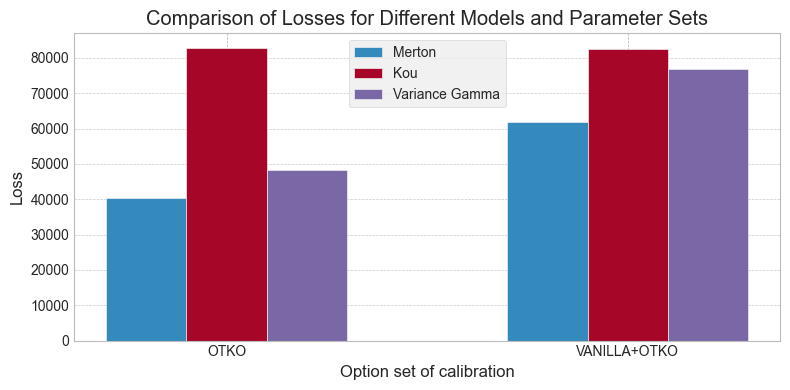

In [24]:
# Extract data for plotting
model_names = ['Merton', 'Kou', 'Variance Gamma']
avg_loss_merton = [avg_loss_merton1, avg_loss_merton2]
avg_loss_kou = [avg_loss_kou1, avg_loss_kou2]
avg_loss_vg = [avg_loss_vg1, avg_loss_vg2]

print(avg_loss_merton, avg_loss_kou, avg_loss_vg)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,4))
ax = plt.gca()
ax.set_facecolor('white')

bar_width = 0.2
index = np.arange(len(options))

# Plot the first group of columns
plt.bar(index - bar_width, avg_loss_merton, bar_width, label='Merton')
plt.bar(index, avg_loss_kou, bar_width, label='Kou')
plt.bar(index + bar_width, avg_loss_vg, bar_width, label='Variance Gamma')

# Add labels, legends, etc.
plt.xlabel('Option set of calibration')
plt.ylabel('Loss')
plt.title(f'Comparison of Losses for Different Models and Parameter Sets',)
plt.xticks(index, options)
plt.legend(loc = 'upper center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.style.use('bmh')

# Show the plot or save it to a file
plt.tight_layout()
plt.show()


### 2. Evaluation of outcomes

#### 2.1 Evaluation of the loss distributions 

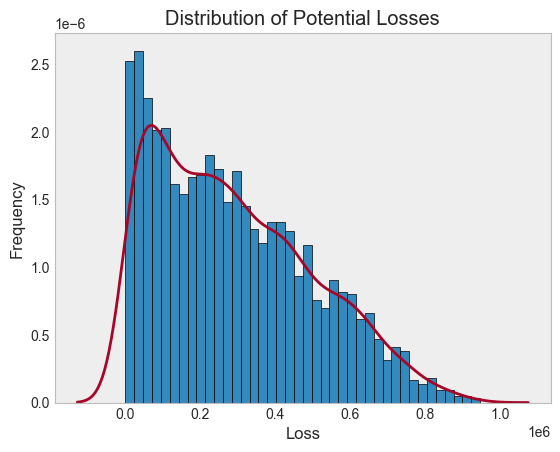

In [25]:
mask = (loss_merton1 != 0)
positive_loss_merton1 = loss_merton1[mask]
 
# Assuming you have a list of potential losses called 'potential_losses'
plt.hist(positive_loss_merton1, density=True, bins=40, edgecolor='black')
sns.kdeplot(positive_loss_merton1, fill=False)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Potential Losses')
plt.grid(); plt.show()


#### 2.2 Evaluation of the profit&loss distribution

##### Merton Jump Diffusion

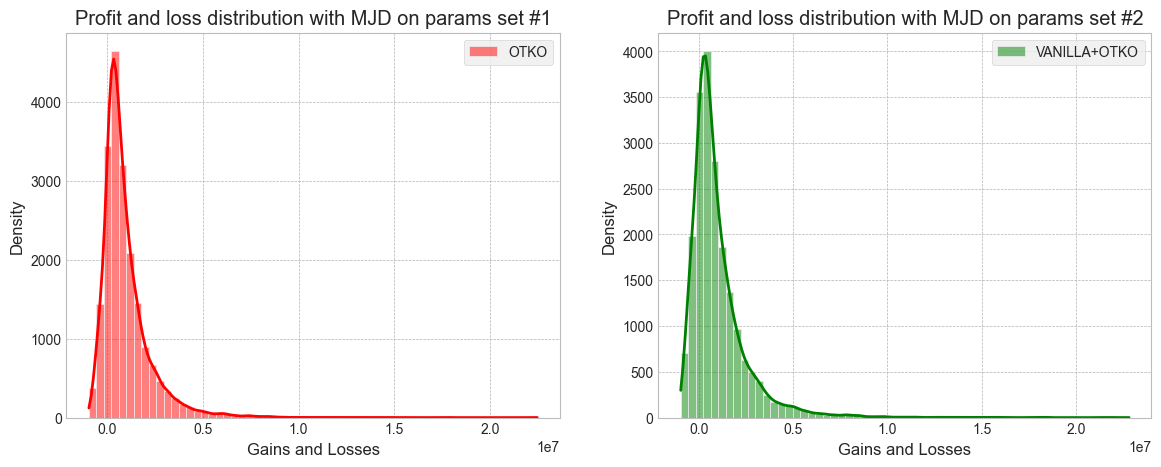

In [26]:
fig2_2, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['red', 'green']

for i in range(2):
    dist_ = f'gain_loss_merton{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_facecolor('white')  
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with MJD on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [27]:
vaR_merton = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Merton model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_merton{i+1}'
    dist = locals()[dist_]
    vaR_merton[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_merton[i]}')

99.0% Value-at-Risk for Merton model: 

> PARAMS SET #1 [OTKO]: -639244.9789878797
> PARAMS SET #2 [VANILLA+OTKO]: -724091.6290773299


##### Kou Jump Diffusion

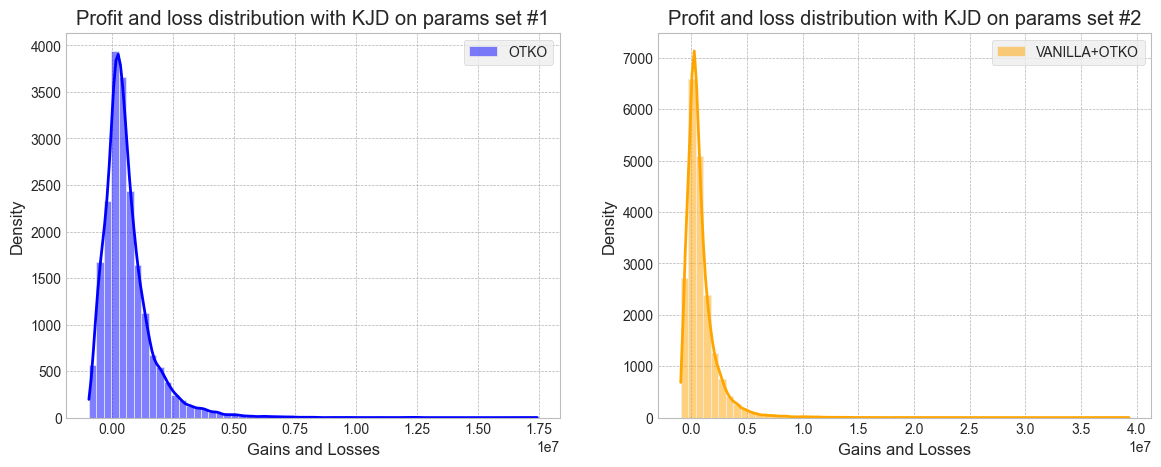

In [28]:
fig2_3, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['blue','orange']

for i in range(2):
    dist_ = f'gain_loss_kou{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_facecolor('white')  
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with KJD on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [29]:
vaR_kou = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Kou model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_kou{i+1}'
    dist = locals()[dist_]
    vaR_kou[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_kou[i]}')

99.0% Value-at-Risk for Kou model: 

> PARAMS SET #1 [OTKO]: -757825.2243714795
> PARAMS SET #2 [VANILLA+OTKO]: -750678.9560727623


##### Variance Gamma model

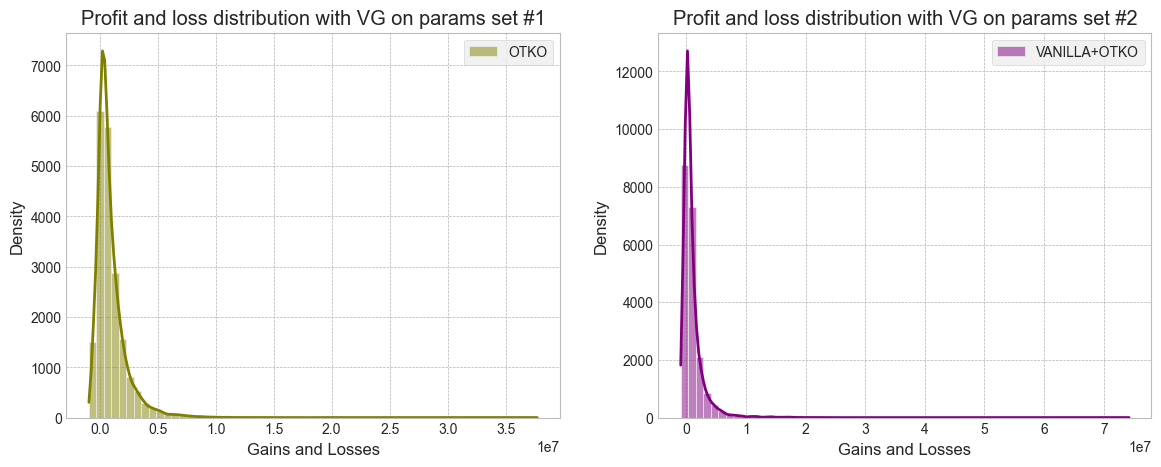

In [30]:
fig2_4, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['olive', 'purple']

for i in range(2):
    dist_ = f'gain_loss_vg{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_facecolor('white')  
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with VG on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [31]:
vaR_vg = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Varinace Gamma model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_vg{i+1}'
    dist = locals()[dist_]
    vaR_vg[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_vg[i]}')

99.0% Value-at-Risk for Varinace Gamma model: 

> PARAMS SET #1 [OTKO]: -662354.2468961924
> PARAMS SET #2 [VANILLA+OTKO]: -740136.8128093635


 ### PRICING OF THE MARGIN LOAN CONTRACT

In [32]:
### MERTON
price= []
price.append(avg_loss_merton1/loan*100)
price.append(avg_loss_merton2/loan*100)
price.append(avg_loss_kou1/loan*100)
price.append(avg_loss_kou2/loan*100)
price.append(avg_loss_vg1/loan*100)
price.append(avg_loss_vg2/loan*100)

print(price)
###

[4.04729, 6.182639, 8.280441000000001, 8.247065, 4.812318, 7.692780000000001]


#### MARGIN LOANS COMPUTATIONS

In [33]:
loan = 1000000          # 1 million
loan_to_value = 0.55
collateral = 1/(loan_to_value / loan)
num_of_shares_at_S0 = round(collateral / last_price,2)
max_shares = num_of_shares_at_S0 * 2
trigger = 0.07       # -10%  
#print(f'> DATE: {datetime.utcnow().strftime("%Y-%m-%d")}')
print(f'> DATE: 2016-01-20')
print(f'> TIME PERIOD: {T} years')
print(f'\n> LOAN: {loan}€ ')
print(f'> LOAN-TO-VALUE ratio: {loan_to_value}')
print(f'> COLLATERAL: {round(collateral,2)}€ ')
print(f'> MARGIN CALL THRESHOLD: -{round(trigger*100,2)}%')
print(f'\n> {symbol} CLOSING PRICE: {round(last_price,2)}')
print(f'\n> INITIAL NUM OF SHARES AS COLLATERAL: {num_of_shares_at_S0}')
print(f'> MAX COLLATERAL SHARES AVAILABLE:  {max_shares}')

> DATE: 2016-01-20
> TIME PERIOD: 3 years

> LOAN: 1000000€ 
> LOAN-TO-VALUE ratio: 0.55
> COLLATERAL: 1818181.82€ 
> MARGIN CALL THRESHOLD: -7.0%

> TSLA CLOSING PRICE: 13.65

> INITIAL NUM OF SHARES AS COLLATERAL: 133219.65
> MAX COLLATERAL SHARES AVAILABLE:  266439.3


#### Merton Jump Diffusion SET #1: OTKO ONLY 


In [34]:
[loss_merton1, gain_loss_merton1] = margin_loan_price1(Smert1, loan)
avg_loss_merton1 = round(np.mean(loss_merton1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton1} €')

Average margin calls: 0.5
Probability of a margin call: 0.0007, 0.06999999999999999%
Average loss: 22515.54
Average profit & loss: 1368839.47
Average num of shares required: 191033.81
LOAN of 1000000 €, LOAN-TO-VALUE 0.55.
According to the Merton model (set #1) the LOSS is 22515.54 €


#### Kou Jump Diffusion SET #1: OTKO ONLY 


In [35]:
[loss_kou1, gain_loss_kou1] = margin_loan_price1(Skou1, loan)
avg_loss_kou1 = round(np.mean(loss_kou1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #1) the LOSS is {avg_loss_kou1} €')

Average margin calls: 0.67
Probability of a margin call: 0.0009, 0.09%
Average loss: 51404.22
Average profit & loss: 947165.77
Average num of shares required: 209048.13
LOAN of 1000000 €, LOAN-TO-VALUE 0.55.
According to the Kou model (set #1) the LOSS is 51404.22 €


#### Variance Gamma SET #1: OTKO ONLY

In [36]:
[loss_vg1, gain_loss_vg1] = margin_loan_price1(Svg1, loan)
avg_loss_vg1 = round(np.mean(loss_vg1), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #1) the LOSS is {avg_loss_vg1} €')

Average margin calls: 0.49
Probability of a margin call: 0.0006, 0.06%
Average loss: 27253.2
Average profit & loss: 1341592.74
Average num of shares required: 193357.27
LOAN of 1000000€, LOAN-TO-VALUE 0.55.
According to the Variance Gamma model (set #1) the LOSS is 27253.2 €


#### Merton Jump Diffusion SET #2: VANILLA+OTKO


In [37]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Smert1[-1])
[loss_merton2, gain_loss_merton2] = margin_loan_price1(Smert2, loan)
avg_loss_merton2 = round(np.mean(loss_merton2), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton2} €')

Average margin calls: 0.6
Probability of a margin call: 0.0008, 0.08%
Average loss: 37769.65
Average profit & loss: 1438946.01
Average num of shares required: 200280.13
LOAN of 1000000 €, LOAN-TO-VALUE 0.55.
According to the Merton model (set #1) the LOSS is 37769.65 €


 #### Kou Jump Diffusion SET #2: VANILLA+OTKO

In [38]:
[loss_kou2, gain_loss_kou2] = margin_loan_price1(Skou2, loan)
avg_loss_kou2 = round(np.mean(loss_kou2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #2) the LOSS is {avg_loss_kou2} €')

Average margin calls: 0.72
Probability of a margin call: 0.001, 0.1%
Average loss: 52042.03
Average profit & loss: 1242638.6
Average num of shares required: 210602.9
LOAN of 1000000€, LOAN-TO-VALUE 0.55.
According to the Kou model (set #2) the LOSS is 52042.03 €


#### Variance Gamma set #2: VANILLA+OTKO

In [39]:
[loss_vg2, gain_loss_vg2] = margin_loan_price1(Svg2, loan)
avg_loss_vg2 = round(np.mean(loss_vg2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #2) the LOSS is {avg_loss_vg2}')

Average margin calls: 0.6
Probability of a margin call: 0.0008, 0.08%
Average loss: 47203.37
Average profit & loss: 1408281.84
Average num of shares required: 203678.57
LOAN of 1000000€, LOAN-TO-VALUE 0.55.
According to the Variance Gamma model (set #2) the LOSS is 47203.37


### Results visualization
#### 1. Average Loss for each model, based on each different set of parameters

[22515.54, 37769.65] [51404.22, 52042.03] [27253.2, 47203.37]


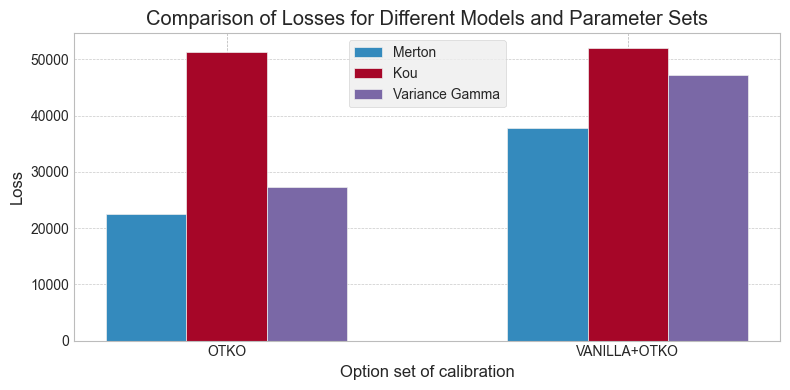

In [40]:
# Extract data for plotting
model_names = ['Merton', 'Kou', 'Variance Gamma']
avg_loss_merton = [avg_loss_merton1, avg_loss_merton2]
avg_loss_kou = [avg_loss_kou1, avg_loss_kou2]
avg_loss_vg = [avg_loss_vg1, avg_loss_vg2]

print(avg_loss_merton, avg_loss_kou, avg_loss_vg)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax = plt.gca()
ax.set_facecolor('white')

bar_width = 0.2
index = np.arange(len(options))

# Plot the first group of columns
plt.bar(index - bar_width, avg_loss_merton, bar_width, label='Merton')
plt.bar(index, avg_loss_kou, bar_width, label='Kou')
plt.bar(index + bar_width, avg_loss_vg, bar_width, label='Variance Gamma')

# Add labels, legends, etc.
plt.xlabel('Option set of calibration')
plt.ylabel('Loss')
plt.title(f'Comparison of Losses for Different Models and Parameter Sets', )
plt.xticks(index, options)
plt.legend(loc='upper center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.style.use('bmh')

# Show the plot or save it to a file
plt.tight_layout()
plt.show()


In [41]:
### MERTON
price= []
price.append(avg_loss_merton1/loan*100)
price.append(avg_loss_merton2/loan*100)
price.append(avg_loss_kou1/loan*100)
price.append(avg_loss_kou2/loan*100)
price.append(avg_loss_vg1/loan*100)
price.append(avg_loss_vg2/loan*100)

print(price)
###

[2.251554, 3.776965, 5.140422, 5.204203, 2.72532, 4.720337]


In [42]:
#### MARGIN LOANS COMPUTATIONS
loan = 1000000  # 1 million
loan_to_value = 0.85
collateral = 1 / (loan_to_value / loan)
num_of_shares_at_S0 = round(collateral / last_price, 2)
max_shares = num_of_shares_at_S0 * 2
trigger = 0.07  # -10%  
#print(f'> DATE: {datetime.utcnow().strftime("%Y-%m-%d")}')
print(f'> DATE: 2016-01-20')
print(f'> TIME PERIOD: {T} years')
print(f'\n> LOAN: {loan}€ ')
print(f'> LOAN-TO-VALUE ratio: {loan_to_value}')
print(f'> COLLATERAL: {round(collateral, 2)}€ ')
print(f'> MARGIN CALL THRESHOLD: -{round(trigger * 100, 2)}%')
print(f'\n> {symbol} CLOSING PRICE: {round(last_price, 2)}')
print(f'\n> INITIAL NUM OF SHARES AS COLLATERAL: {num_of_shares_at_S0}')
print(f'> MAX COLLATERAL SHARES AVAILABLE:  {max_shares}')

> DATE: 2016-01-20
> TIME PERIOD: 3 years

> LOAN: 1000000€ 
> LOAN-TO-VALUE ratio: 0.85
> COLLATERAL: 1176470.59€ 
> MARGIN CALL THRESHOLD: -7.0%

> TSLA CLOSING PRICE: 13.65

> INITIAL NUM OF SHARES AS COLLATERAL: 86200.95
> MAX COLLATERAL SHARES AVAILABLE:  172401.9


#### Merton Jump Diffusion SET #1: OTKO ONLY 

In [43]:
[loss_merton1, gain_loss_merton1] = margin_loan_price1(Smert1, loan)
avg_loss_merton1 = round(np.mean(loss_merton1), 2)
print(
    f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton1} €')

Average margin calls: 1.61
Probability of a margin call: 0.0021, 0.21%
Average loss: 61981.9
Average profit & loss: 717079.64
Average num of shares required: 135768.85
LOAN of 1000000 €, LOAN-TO-VALUE 0.85.
According to the Merton model (set #1) the LOSS is 61981.9 €


#### Kou Jump Diffusion SET #1: OTKO ONLY 

In [44]:
[loss_kou1, gain_loss_kou1] = margin_loan_price1(Skou1, loan)
avg_loss_kou1 = round(np.mean(loss_kou1), 2)
print(
    f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #1) the LOSS is {avg_loss_kou1} €')

Average margin calls: 1.93
Probability of a margin call: 0.0026, 0.26%
Average loss: 117460.88
Average profit & loss: 404768.34
Average num of shares required: 145659.52
LOAN of 1000000 €, LOAN-TO-VALUE 0.85.
According to the Kou model (set #1) the LOSS is 117460.88 €


#### Variance Gamma SET #1: OTKO ONLY

In [45]:
[loss_vg1, gain_loss_vg1] = margin_loan_price1(Svg1, loan)
avg_loss_vg1 = round(np.mean(loss_vg1), 2)
print(
    f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #1) the LOSS is {avg_loss_vg1} €')

Average margin calls: 1.55
Probability of a margin call: 0.0021, 0.21%
Average loss: 72775.26
Average profit & loss: 696884.05
Average num of shares required: 137016.76
LOAN of 1000000€, LOAN-TO-VALUE 0.85.
According to the Variance Gamma model (set #1) the LOSS is 72775.26 €


#### Merton Jump Diffusion SET #2: VANILLA + OTKO 

In [46]:
[loss_merton2, gain_loss_merton2] = margin_loan_price1(Smert2, loan)
avg_loss_merton2 = round(np.mean(loss_merton2), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton2} €')

Average margin calls: 1.78
Probability of a margin call: 0.0023, 0.22999999999999998%
Average loss: 88862.71
Average profit & loss: 759809.77
Average num of shares required: 140376.46
LOAN of 1000000 €, LOAN-TO-VALUE 0.85.
According to the Merton model (set #1) the LOSS is 88862.71 €


#### Kou Jump Diffusion SET #2: VANILLA + OTKO 

In [47]:
[loss_kou2, gain_loss_kou2] = margin_loan_price1(Skou2, loan)
avg_loss_kou2 = round(np.mean(loss_kou2), 2)
print(
    f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #2) the LOSS is {avg_loss_kou2} €')

Average margin calls: 2.07
Probability of a margin call: 0.0027, 0.27%
Average loss: 115552.05
Average profit & loss: 615227.59
Average num of shares required: 146238.49
LOAN of 1000000€, LOAN-TO-VALUE 0.85.
According to the Kou model (set #2) the LOSS is 115552.05 €


#### Variance Gamma set #2: VANILLA+OTKO

In [48]:
[loss_vg2, gain_loss_vg2] = margin_loan_price1(Svg2, loan)
avg_loss_vg2 = round(np.mean(loss_vg2), 2)
print(
    f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #2) the LOSS is {avg_loss_vg2}')

Average margin calls: 1.73
Probability of a margin call: 0.0023, 0.22999999999999998%
Average loss: 109262.66
Average profit & loss: 739661.58
Average num of shares required: 142602.73
LOAN of 1000000€, LOAN-TO-VALUE 0.85.
According to the Variance Gamma model (set #2) the LOSS is 109262.66


### Results visualization

#### 1. Average Loss for each model, based on each different set of parameters

[61981.9, 88862.71] [117460.88, 115552.05] [72775.26, 109262.66]


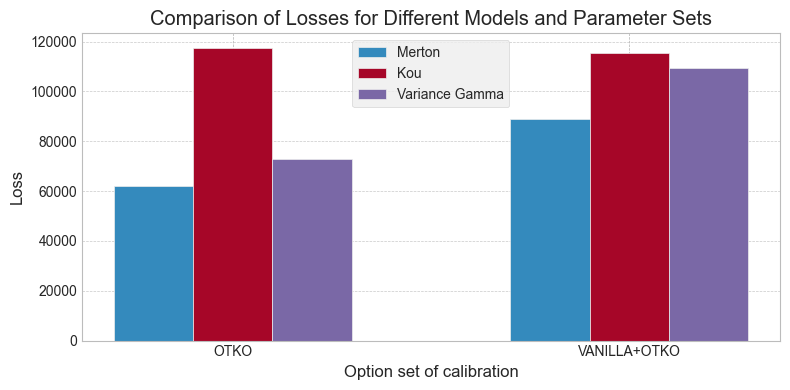

In [49]:
# Extract data for plotting
model_names = ['Merton', 'Kou', 'Variance Gamma']
avg_loss_merton = [avg_loss_merton1, avg_loss_merton2]
avg_loss_kou = [avg_loss_kou1, avg_loss_kou2]
avg_loss_vg = [avg_loss_vg1, avg_loss_vg2]

print(avg_loss_merton, avg_loss_kou, avg_loss_vg)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax = plt.gca()
ax.set_facecolor('white')

bar_width = 0.2
index = np.arange(len(options))

# Plot the first group of columns
plt.bar(index - bar_width, avg_loss_merton, bar_width, label='Merton')
plt.bar(index, avg_loss_kou, bar_width, label='Kou')
plt.bar(index + bar_width, avg_loss_vg, bar_width, label='Variance Gamma')

# Add labels, legends, etc.
plt.xlabel('Option set of calibration')
plt.ylabel('Loss')
plt.title(f'Comparison of Losses for Different Models and Parameter Sets', )
plt.xticks(index, options)
plt.legend(loc='upper center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.style.use('bmh')

# Show the plot or save it to a file
plt.tight_layout()
plt.show()


#### Interest rate computation

In [50]:

price = []
price.append(avg_loss_merton1 / loan * 100)
price.append(avg_loss_merton2 / loan * 100)
price.append(avg_loss_kou1 / loan * 100)
price.append(avg_loss_kou2 / loan * 100)
price.append(avg_loss_vg1 / loan * 100)
price.append(avg_loss_vg2 / loan * 100)

print(price)


[6.19819, 8.886271, 11.746088, 11.555205, 7.277525999999999, 10.926266]
